### Notebook to visualize mutations in de-novo degron in comparison with mutations in other regions of the protein

In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import gridspec
from scipy import stats
import pickle

### paths

In [13]:
base="../" 


dataset_rppa_irls_tcga = os.path.join(base,"data/rppa_matched_irls.tsv.gz")

path_output_missense_degrons_rppa_tcga = os.path.join(base,"data","missense_clean_type_rppa.tsv.gz")
path_output_indels_degrons_rppa_tcga = os.path.join(base,"data","indels_clean_type_rppa.tsv.gz")

path_denovo_degrons = os.path.join(base,"data","de_novo_degrons.tsv")
output_path_antibodies = os.path.join(base,"data","antibodies_figure4.tsv")

output_path_plots = os.path.join(base,"plots","Figure4","boxplots")

output_dict_ylims = os.path.join(base,"data","ylims.pickle")

### read TCGA data

In [14]:
df_missense_raw = pd.read_csv(path_output_missense_degrons_rppa_tcga,sep="\t",compression="gzip")
df_indels_raw = pd.read_csv(path_output_indels_degrons_rppa_tcga,sep="\t",compression="gzip")
df_all_rppa = pd.read_csv(dataset_rppa_irls_tcga,sep="\t",compression="gzip")

### Load de-novo degrons

In [15]:
df_denovo = pd.read_csv(path_denovo_degrons,sep="\t")
df_antibodies = pd.read_csv(output_path_antibodies,sep="\t")
df_denovo=df_denovo.merge(df_antibodies)
d_ylims = pickle.load(open(output_dict_ylims,'rb'))

### Function to plot the boxpltos

In [25]:
def plot_boxplot(df_total,degron):
    p = {"Other_Alterations":"#cc0000","Alteration_Degron":"#d98cb3","WT":"#4682B4","Alteration_E3_Ligase":"#FFA500"}
    s = ["Alteration_Degron","Other_Alterations","WT"]
    datasets = ["TCGA"]
    fig,ax = plt.subplots(nrows=1,ncols=1)
    fig.set_size_inches(0.75, 0.85)
    #fig.set_size_inches(5.25, 10)
    size_strip=3
    #g = sns.stripplot(data=df_total[(df_total["Type"].str.contains("Other_Alterations"))&(df_total["Phenotype"]=="Missense_Mutation")],x="Type",y="Stability_Change",alpha=0.7,size=size_strip,palette=p,jitter=True,dodge=True,order=s)
    g = sns.stripplot(data=df_total[(df_total["Type"].str.contains("Alteration_Degron"))&(df_total["Phenotype"]=="Missense_Mutation")],x="Type",y="Stability_Change",alpha=0.7,size=size_strip,palette=p,jitter=True,dodge=True,order=s)
    g = sns.stripplot(data=df_total[(df_total["Type"].str.contains("Alteration_Degron"))&(df_total["Phenotype"].str.contains("In_Frame"))],x="Type",y="Stability_Change",alpha=0.7,size=size_strip,palette=p,jitter=True,dodge=True,order=s,marker="^")
    sns.boxplot(x="Type",y="Stability_Change",data=df_total,width=0.6,saturation=0.7,palette=p,fliersize=0.,ax=ax, linewidth=1,whis=0.9,notch=False,order=s)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:0], labels[0:0], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # TCGA analysis

    N_alteration = df_total[(df_total["Type"]=="Alteration_Degron")&(df_total["Dataset"]=="TCGA")].shape[0]
    N_other = df_total[(df_total["Type"]=="Other_Alterations")&(df_total["Dataset"]=="TCGA")].shape[0]
    N_wt = df_total[(df_total["Type"]=="WT")&(df_total["Dataset"]=="TCGA")].shape[0]
    print (degron,df_total["Protein"].values[0],N_alteration,N_other,N_wt)
    # Write numbers of N

    maxv = np.nanmax(list(df_total[(df_total["Type"]!="WT")&(df_total["Dataset"]=="TCGA")]["Stability_Change"].values))
    minv = np.nanmin(list(df_total[(df_total["Type"]!="WT")&(df_total["Dataset"]=="TCGA")]["Stability_Change"].values))

    ax.text(y=maxv+0.4,x=-0.30,s="N="+str(N_alteration),fontsize=6)



    # Calculate significance 
    # TCGA

    pvalue_motif_wt = stats.mannwhitneyu(df_total[(df_total["Type"]=="Alteration_Degron")&(df_total["Dataset"]=="TCGA")]["Stability_Change"].values,df_total[(df_total["Type"]=="WT")&(df_total["Dataset"]=="TCGA")]["Stability_Change"].values,alternative="greater")[1]
    pvalue_motif_mt = stats.mannwhitneyu(df_total[(df_total["Type"]=="Alteration_Degron")&(df_total["Dataset"]=="TCGA")]["Stability_Change"].values,df_total[(df_total["Type"]=="Other_Alterations")&(df_total["Dataset"]=="TCGA")]["Stability_Change"].values,alternative="greater")[1]

    ax.axhline(y=maxv+0.7,xmin=0.10,xmax=0.20,color="black",linewidth=0.25)
    if pvalue_motif_wt < 0.05:
        ax.text(y=maxv+1.2,x=-0.30,s="P="+str("{0:.2E}".format(pvalue_motif_wt)),fontsize=4)
    else:
        ax.text(y=maxv+1.2,x=-0.30,s="P=n.s.",fontsize=4)

    if pvalue_motif_mt < 0.05:
        ax.text(y=maxv+0.8,x=-0.30,s="P="+str("{0:.2E}".format(pvalue_motif_mt)),fontsize=4)
    else:
        ax.text(y=maxv+0.8,x=-0.30,s="P=n.s.",fontsize=4)





    ax.set_ylabel("Stability Change",fontsize=4)
    ax.set_xlabel("",fontsize=4)
    ax.set_xticks([])


    ylim = (d_ylims[row["Entry_Isoform"]][0],d_ylims[row["Entry_Isoform"]][1])
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0],ylim[1]+1,1))
    ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.15)
    #ax.tick_params(axis = 'x', labelsize =6  , pad=0.5 ,width=0.0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.15)
    ax.spines['bottom'].set_linewidth(0.15)
    protein = df_total["Protein"].unique()[0]
    name = protein+"_"+degron
    #ax.set_xlabel(name,fontsize=6)
    plt.savefig(output_path_plots+"/"+name+".pdf",bbox_inches="tight")

### aux function 

In [22]:
def is_in_degron(positions,start,end):
    l_values = []
    for pos in positions.values:
        try:
            int_pos = int(pos)
        except ValueError:
            int_pos = int(pos.split("-")[0])
        l_values.append((int_pos >= start) and (int_pos <= end))
    return pd.Series(l_values)

### Run all the cases

ARAF_pS299


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

202-215 ARAF_pS299 3 35 6735
BRAF_pS445


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


330-347 BRAF_pS445 2 385 6313
BRCA2
3393-3398 BRCA2 2 86 5756
CAVEOLIN1
6-10 CAVEOLIN1 2 14 6733
NCADHERIN
354-362 NCADHERIN 2 91 6625
CHK1_pS296
261-333 CHK1_pS296 9 14 6725
EGFR
1015-1044 EGFR 2 72 6222
HER3_pY1289
1298-1306 HER3_pY1289 2 125 6580
FOXO3A
389-437 FOXO3A 4 23 6715
GATA3
101-117 GATA3 2 45 6575
GATA3


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


350-358 GATA3 2 46 6575
ERK2
308-332 ERK2 11 15 6625
CD20
250-272 CD20 3 30 6819
CD20
265-270 CD20 2 31 6819
HEREGULIN
375-384 HEREGULIN 3 51 19684
PI3KP85
562-567 PI3KP85 11 37 6596
PKCALPHA
628-633 PKCALPHA 2 28 6516
SHC_pY317
51-56 SHC_pY317 2 22 6520
X53BP1
1312-1385 X53BP1 5 84 6666


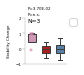

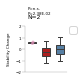

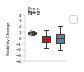

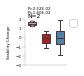

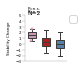

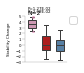

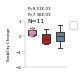

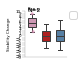

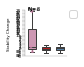

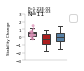

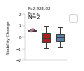

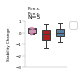

In [26]:
for index,row in df_denovo.iterrows():
    start = row["START"]
    end = row["END"]
    protein = row["Protein"]
    print (protein)


    # Wild type
    df_wt = df_all_rppa[(df_all_rppa["Phenotype"]=="WT")&(df_all_rppa["CNA"]<=1)&(df_all_rppa["CNA"]>=-1)&(df_all_rppa["Protein"]==protein)&(~df_all_rppa["Altered_E3_Ligases"])]
    df_wt["Type"] = "WT"
    # Other alterations
    # Missense
    df_missense_other = df_missense_raw[(df_missense_raw["Type_Missense"]=="Other_Missense")&(df_missense_raw["CNA"]<=1)
                                        &(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Protein"]==protein)
                                        &(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])
                                        &(df_missense_raw["Stability_Change"]<0)))
                                        &(~is_in_degron(df_missense_raw["Protein_position"],start,end))]
    df_missense_other["Type"] = "Other_Alterations"
    # Indels
    df_indels_other = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"]=="Other_In_Frame")
                                    &(df_indels_raw["Phenotype"].str.contains("In_Frame"))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)
                                    &(df_indels_raw["Protein"]==protein)&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])
                                    &(df_indels_raw["Stability_Change"]<0)))&(~is_in_degron(df_indels_raw["Protein_position"],start,end))]
    df_indels_other["Type"] = "Other_Alterations"
    # Alterations degron
    # missense
    df_missense_degron = df_missense_raw[(df_missense_raw["Type_Missense"]=="Other_Missense")&(df_missense_raw["CNA"]<=1)
                                        &(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Protein"]==protein)
                                        &(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])
                                        &(df_missense_raw["Stability_Change"]<0)))
                                        &(is_in_degron(df_missense_raw["Protein_position"],start,end))]
    df_missense_degron["Type"] = "Alteration_Degron"
    # indel
    df_indels_degron = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"]=="Other_In_Frame")
                                    &(df_indels_raw["Phenotype"].str.contains("In_Frame"))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)
                                    &(df_indels_raw["Protein"]==protein)&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])
                                    &(df_indels_raw["Stability_Change"]<0)))&(is_in_degron(df_indels_raw["Protein_position"],start,end))]
    df_indels_degron["Type"] = "Alteration_Degron"

    columns = ["Type","Stability_Change","Phenotype","Protein"]


    df_total_tcga = pd.concat([df_wt[columns],df_missense_other[columns],df_missense_degron[columns],df_indels_degron[columns]])
    df_total_tcga["Dataset"] = "TCGA"
    plot_boxplot(df_total_tcga,str(start)+"-"+str(end))
    
